#Analysis of Cancer Gene Expression Data

#####Python main module imports for data analysis

The purpose of this analysis is to implement elastic net regularization on logistic regression to perform feature selection and classication tasks on genetic data

In [1]:
# Data Imports
import numpy as np
import pandas as pd
from pandas import Series,DataFrame
from scipy.stats import norm


# Math
import math

# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Preprocessing Imports
from sklearn.preprocessing import normalize

# Machine Learning Imports
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


from sklearn.linear_model import RandomizedLogisticRegression
from sklearn.cross_validation import train_test_split

# For evaluating our ML results
from sklearn import metrics
from sklearn.metrics import roc_auc_score, confusion_matrix

# For Spectral Clustering algorithms
from sklearn import cluster
from sklearn.neighbors import kneighbors_graph

# network imports
import networkx as nx
import igraph as ig

Couldn't import dot_parser, loading of dot files will not be possible.


###Data Cleaning

#####Choose the data set:

In [3]:
# read data file
datafile = '~/Documents/THESIS/data/ICOS_DATA/breast_preprocessed.txt'
data = pd.read_table(datafile, delim_whitespace = True, 
                     dtype={'a': np.float64}, header = None)

/home/jcapitz/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1170: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [4]:
# data dimension
print data.shape
# last 5 rows of the data
data.tail()

(47294, 129)


,0,1,2,3,4,5,6,7,8,9,...,119,120,121,122,123,124,125,126,127,128
47289,lysA,5.68,5.7194,5.7592,5.6898,5.7236,5.662,5.6684,5.6742,5.6669,...,5.7164,5.7175,5.7133,5.7133,5.6753,5.6679,5.6692,5.7666,5.72,5.75
47290,pheA,5.705,5.6142,5.6955,5.6227,5.6727,5.5995,5.633,5.6539,5.6511,...,5.6595,5.6292,5.6042,5.6266,5.6022,5.6709,5.6136,5.6038,5.6693,5.5818
47291,thrB,5.7077,5.7586,5.7279,5.6777,5.6761,5.7091,5.6777,5.68,5.6763,...,5.6918,5.6501,5.5772,5.6637,5.6556,5.6587,5.6987,5.6933,5.6775,5.68
47292,trpF,5.6684,5.6585,5.6337,5.6427,5.6371,5.6691,5.62,5.6199,5.6608,...,5.6392,5.6451,5.6149,5.551,5.605,5.6246,5.5404,5.6206,5.6552,5.6141
47293,y,luminal,luminal,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,...,luminal,luminal,luminal,non-luminal,non-luminal,luminal,luminal,luminal,non-luminal,luminal


In [5]:
# extract colum names (all but last one are gene names).
colNames = data[0]
colNames = list(colNames)

In [6]:
# housekeepnig genes
hkfile = '~/Documents/THESIS/data/HK_exons.csv'

hkdata = pd.read_csv(hkfile)

hknames = hkdata['Gene Name']

In [7]:
# Checking to see how many housekeeping genes in the dataset 
sum(hknames.isin(colNames))

0

In [9]:
# tranpose the data to have genes as columns and microarray experiment as rows
data2 = data.T.ix[1:]

# reset the index to satrt at 0
data2 = data2.reset_index(drop=True)

# add colum labels
data2.columns=colNames
data2.head()

,GI_10047089-S,GI_10047091-S,GI_10047093-S,GI_10047099-S,GI_10047103-S,GI_10047105-S,GI_10047121-S,GI_10047123-S,GI_10047133-A,GI_10047133-I,...,hmm9738-S,hmm974-S,hmm9750-S,hmm9917-S,hmm9988-S,lysA,pheA,thrB,trpF,y
0,5.3416,5.846,6.7052,6.4184,8.6651,5.7238,5.7566,6.8052,5.6885,5.8921,...,5.5959,5.8873,5.8005,5.5931,5.746,5.68,5.705,5.7077,5.6684,luminal
1,5.6259,5.8742,6.8089,6.6955,8.6113,5.8368,5.6288,7.7121,5.6911,6.0818,...,5.5832,5.7613,5.6705,5.7903,5.6111,5.7194,5.6142,5.7586,5.6585,luminal
2,5.6181,5.8026,6.6975,6.5851,8.3808,5.7835,5.8264,7.1011,5.6057,5.4915,...,5.5109,5.6742,5.7253,5.6365,5.4889,5.7592,5.6955,5.7279,5.6337,luminal
3,5.5602,5.8394,6.8386,6.7055,8.4486,5.5497,5.8045,7.6032,5.5867,5.7122,...,5.6254,5.8001,5.7344,5.6971,5.4883,5.6898,5.6227,5.6777,5.6427,luminal
4,5.5385,5.8876,6.572,6.1651,8.8246,5.7474,5.821,7.4015,5.6479,5.8412,...,5.7101,5.8066,5.6583,5.7032,5.58,5.7236,5.6727,5.6761,5.6371,luminal


In [10]:
# create date set with genes only. This is the features matrix
X = data2[range(data.shape[0]-1)]
print X.shape

# make sure data type is float and not string.
X = X.astype(float)

(128, 47293)


In [11]:
# store the gene names/ids
geneNames = X.columns

In [12]:
# create vector with response variable
Y = data2[[-1]]
Y.head().dtypes

y    object
dtype: object

In [13]:
# make sure response vector is binary 0, 1.
Y = pd.get_dummies(Y)
Y.head(6)

,y_luminal,y_non-luminal
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,0,1


In [14]:
# choose one of the equivalent response vectors.
Y = Y.ix[:,0]

In [15]:
#Percent of cancer positive
np.mean(Y)

0.65625

In [16]:
#Y = np.ravel(Y)

##Classification with Penalized Logistic Model

In [17]:
# model definition
# logistic regression with elasticnet regularization
# l1_ratio refers to alpha and alpha refers to lamba in Hastie
log_model = SGDClassifier(loss = 'log', penalty = 'elasticnet', alpha = 0.175, 
                                l1_ratio = 0.5, fit_intercept = True)

###Significant Gene Selection Cross-Validation

In [18]:
#initialize the dataframes for ranking genes
selected_genes = {'col1':'gene1'}
gene_names = DataFrame(geneNames)
gene_names.columns = ['trial0']

# Initial trial column 
gene_select_count = gene_names.isin(selected_genes)
gene_coeff = DataFrame()

# Number of trials
M = 500

# IN THE LOOP
for i in range(M):
    # Split the data

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y)


    # Fit model and select significant genes

    fit_log_model = log_model.fit(X_train, Y_train)
    X_selected = fit_log_model.transform(X_test)


    # Find the indexes of significant genes

    # these are the index of the features selected by the l1 regularized logistic model
    selected_index = np.where(log_model.coef_!=0)[-1]
    # Selected genes in ith trial
    selected_genes = gene_names.loc[selected_index]

    gene_select_count['trial' + str(i)] = gene_names.isin(selected_genes)
    gene_coeff['trial' + str(i)] = Series(log_model.coef_[0])
    

In [19]:
beta_coeff = gene_coeff.mean(axis = 1)
beta_sterror = gene_coeff.std(axis = 1)
gene_imp_score = gene_coeff.mean(axis = 1).abs()
pvalue = 1-norm.cdf(np.abs(beta_coeff/beta_sterror))

In [20]:
# this creates a pandas Series with the sum of how many times a gene was selected
gene_select_summary = gene_select_count.sum(axis = 1)

In [21]:
# this data frame has the values for all genes
result = DataFrame([geneNames, gene_select_summary, gene_imp_score, beta_coeff, beta_sterror, pvalue], index = 
          ['Gene', 'Frequency', 'Score', 'Coefficient', 'Std Error', 'pvalue']).T.sort(['Frequency', 'Score'], 
                                                            ascending = False)

In [22]:
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head()

,Gene,Frequency,Coefficient,Std Error,pvalue
22089,GI_4503602-S,500,3.005879,0.762559,4.043104e-05
5644,GI_21614543-S,500,-1.979327,0.5884984,0.0003850117
17275,GI_38455428-S,500,1.935199,0.7161242,0.003442839
26033,GI_9951924-S,500,1.576836,0.5958833,0.004069894
10064,GI_29738585-S,500,1.439875,0.5185348,0.00274472


In [23]:
GI_4503602_S = X['GI_4503602-S']
GI_21614543_S = X['GI_21614543-S']

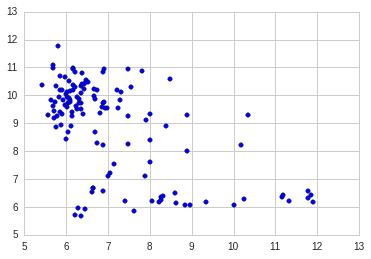

In [24]:
#plt.scatter(range(128),GI_4503602_S)
plt.scatter(GI_21614543_S,GI_4503602_S)
plt.show()

In [25]:
# this gives the indices of selected genes according to some threshold. can use the importance score
# or the number of times selected.
selected_genes_index = gene_select_summary[gene_imp_score >= 1.5].index

In [26]:
result = DataFrame([geneNames[selected_genes_index], gene_select_summary[selected_genes_index], 
           gene_imp_score[selected_genes_index], beta_coeff[selected_genes_index], beta_sterror[selected_genes_index],
           pvalue[selected_genes_index]], index = ['Gene', 'Frequency', 'Score','Coefficient', 'Std Error', 
                                                   'pvalue']).T.sort(['Frequency', 'Score'], 
                                                                     ascending = False).head()

In [27]:
print len(selected_genes_index)
result[['Gene', 'Frequency', 'Coefficient', 'Std Error', 'pvalue']].head(10)

6


,Gene,Frequency,Coefficient,Std Error,pvalue
2,GI_4503602-S,500,3.005879,0.762559,4.043104e-05
0,GI_21614543-S,500,-1.979327,0.5884984,0.0003850117
1,GI_38455428-S,500,1.935199,0.7161242,0.003442839
5,GI_9951924-S,500,1.576836,0.5958833,0.004069894
3,GI_4503928-S,499,1.53295,0.614473,0.006302485


In [28]:
# these are the names of the selected genes
DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index).head()
len(DataFrame(geneNames[selected_genes_index], columns = ['Selected Genes'], index = selected_genes_index))

6

In [29]:
#Need to create X_sel

X_sel = X[selected_genes_index]

X_sel.shape

(128, 6)

In [30]:
# this gives the model's score
log_model.fit(X_sel,Y)
print log_model.score(X_sel,Y)

0.8359375


In [31]:
class_prob = log_model.predict_proba(X_sel)

In [32]:
class_prob.shape

(128, 2)

In [33]:
dfprob = DataFrame(class_prob)
print dfprob.mean()

0    0.260124
1    0.739876
dtype: float64


###Cross Validation

In [34]:
# Make a new log_model
#log_model2 = LogisticRegression()
log_model2 = LogisticRegression(dual = False, fit_intercept = True)

xvalacc = []
xvalROC = []
M = 1000

for i in range(M):

    # Split the data
    X_train, X_test, Y_train, Y_test = train_test_split(X_sel, Y)

    # Now fit the new model
    log_model2.fit(X_train, Y_train)

    # Predict the classes of the testing data set
    class_predict = log_model2.predict(X_test)

    # Compare the predicted classes to the actual test classes
    xvalacc.append(metrics.accuracy_score(Y_test,class_predict))
    try:
        xvalROC.append(roc_auc_score(Y_test,class_predict))
    except ValueError:
        pass

In [35]:
np.std(xvalacc)

0.056022979381232484

In [36]:
np.mean(xvalacc)

0.86906249999999996

In [37]:
np.std(xvalROC)

0.067859899341781965

In [38]:
np.mean(xvalROC)

0.84429004932331797

In [39]:
class_predict

array([ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,
        1.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  0.,  1.])

In [40]:
roc_auc_score(Y_test,class_predict)

0.97999999999999998

In [41]:
confusion_matrix(Y_test,class_predict)

array([[ 7,  0],
       [ 1, 24]])

In [42]:
np.corrcoef(X_sel)

array([[ 1.        ,  0.98003971,  0.92358007, ...,  0.94872624,
        -0.16076295,  0.90001349],
       [ 0.98003971,  1.        ,  0.96296069, ...,  0.98372621,
        -0.26359964,  0.95448512],
       [ 0.92358007,  0.96296069,  1.        , ...,  0.94196332,
        -0.41897343,  0.97977432],
       ..., 
       [ 0.94872624,  0.98372621,  0.94196332, ...,  1.        ,
        -0.35026681,  0.94084915],
       [-0.16076295, -0.26359964, -0.41897343, ..., -0.35026681,
         1.        , -0.48683735],
       [ 0.90001349,  0.95448512,  0.97977432, ...,  0.94084915,
        -0.48683735,  1.        ]])